In [1]:
import sys
import numpy as np
import spectral as sp
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm

sys.path.append('../')
from preprocessing import *
from unmixing_algorithms import *
from extinctions import *
from plotting_parameters import *
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

### Load endmember spectra

In [2]:
bands_range = [520,900]
band_centers = np.arange(bands_range[0], bands_range[1]+1)

extinction_dict = get_extinctions(bands_range)
cyt_c_ox = extinction_dict["cyt_c_ox"]
cyt_c_red = extinction_dict["cyt_c_red"]
cyt_b_ox = extinction_dict["cyt_b_ox"]
cyt_b_red = extinction_dict["cyt_b_red"]
cyt_oxi_ox = extinction_dict["cyt_oxi_ox"]
cyt_oxi_red = extinction_dict["cyt_oxi_red"]
hb = extinction_dict["hb"]
hbo2 = extinction_dict["hbo2"]
water = extinction_dict["water"]
fat = extinction_dict["fat"]
ones = np.ones_like(water)
scatter_ray = (band_centers/500)**(-4)

# remove cytochrome difference spectra as they are not needed for helicoid
_ = extinction_dict.pop("cyt_c_diff")
_ = extinction_dict.pop("cyt_b_diff")
_ = extinction_dict.pop("cyt_oxi_diff")


extinction_array = np.vstack([extinction_dict[key] for key in extinction_dict.keys()])

M = np.vstack((cyt_oxi_ox, cyt_oxi_red, hb, hbo2, water, fat)).T
endmember_labels = ["Cyt oxi ox", "Cyt oxi red", "Hb", "HbO2", "Water", "Fat"]

M_scatter = np.vstack((cyt_oxi_ox, cyt_oxi_red, hb, hbo2, water, fat, scatter_ray)).T
endmember_labels_scatter = ["Cyt oxi ox", "Cyt oxi red", "Hb", "HbO2", "Water", "Fat", "ones"]

### Load Hyperspectral image

/home/martin_ivan/anaconda3/envs/thesis/lib/python3.10/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(<Figure size 640x480 with 1 Axes>, <Axes: >)

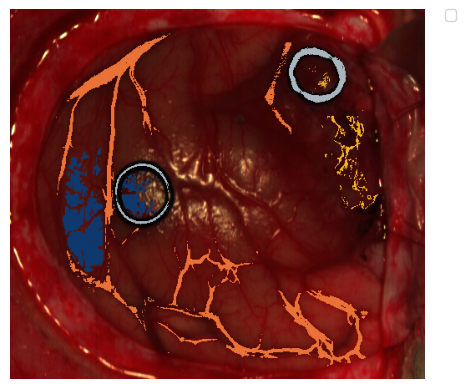

In [3]:
data_folder = "../../datasets/helicoid/012-01"
class_labels = ["Not labled", "Normal", "Tumor", "Blood", "Background"]
class_colors = ["white", tum_blue_dark_2, tum_orange, tum_red, tum_grey_5]

# Load the sp data
img = sp.open_image(data_folder + "/raw.hdr")
white_ref = sp.open_image(data_folder + "/whiteReference.hdr")
dark_ref = sp.open_image(data_folder + "/darkReference.hdr")
gt_map = sp.open_image(data_folder + "/gtMap.hdr")

plot_img(img, gt_map, class_labels, class_colors, figsize=(5,5), legend=True)

In [4]:
# linearly interpolate the bands to the desired range
img, band_centers = bands_lin_interpolation(img, img.bands.centers, bands_range)
white_ref, _ = bands_lin_interpolation(white_ref, white_ref.bands.centers, bands_range)
dark_ref, _ = bands_lin_interpolation(dark_ref, dark_ref.bands.centers, bands_range)

img_calib = calibrate_img(img, white_ref, dark_ref)
img_smooth = smooth_spectral(img_calib, 5)
absorbance = -np.log(img_smooth - np.min(img_smooth.flatten()) + 1e-8)

# remove dark reference from the image
R = np.subtract(img, dark_ref, dtype=np.float32)
R = torch.from_numpy(R).to("cuda").float()

# compute projection matrix onto the orthogonal complement of the white reference
E = np.mean(np.subtract(white_ref, dark_ref, dtype=np.float32), axis=-2).squeeze()
E = smooth_spectral(E, 5)
P_E = np.eye(E.shape[0]) - np.outer(E, E)/np.dot(E, E)
P_E = torch.from_numpy(P_E).to("cuda").float()

# project data to the orthogonal complement of the white reference
img_proj = torch.einsum('ij,...j->...i', P_E, R) 

img_proj = img_proj.cpu().numpy()
P_E = P_E.cpu().numpy()

### Plotting functions

In [5]:
def plot_concentrations(c, endmember_labels=None, figsize=(15,5)):
    N = c.shape[2]
    if N < 5:
        fig, axs = plt.subplots(1, N, figsize=figsize)
        for i in range(N):
            axs[i].imshow(c[:,:,i])
            axs[i].set_title(endmember_labels[i])
            axs[i].axis("off")
            # add colorbar
            divider = make_axes_locatable(axs[i])
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(axs[i].images[0], cax=cax)
    else:
        fig, axs = plt.subplots(int(np.ceil(N/5)), 5, figsize=figsize)
        for i in range(N):
            axs[i//5,i%5].imshow(c[:,:,i])
            axs[i//5,i%5].set_title(endmember_labels[i])
            axs[i//5,i%5].axis("off")
            # add colorbar
            divider = make_axes_locatable(axs[i//5,i%5])
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(axs[i//5,i%5].images[0], cax=cax)
    _ = plt.tight_layout()
    return fig, axs

def plot_error_img(err):
    fig, ax = plt.subplots(1,1, figsize=(3,3))
    err_img = plt.imshow(np.linalg.norm(err, axis=2))
    print(np.linalg.norm(err.flatten()))
    fig.colorbar(err_img, ax=ax)
    return fig, ax

### Spectral fit optimization

Projection matrix onto orhogonal complement of white reference: $P^\perp_\text{E}$

Beer-Lambert Law: $I = I_\text{white} e^{\textbf{M}c}$, with endmember matrix $\textbf{M}$ and concentration vector $c$

$\Rightarrow \quad P^\perp_\text{E} (I_\text{raw} - I_\text{dark}) = P^\perp_\text{E} I_\text{white} e^{\textbf{M}c}\\\\$
$\Rightarrow c = \underset{c}\argmin \quad \| P^\perp_\text{E} (I_\text{raw} - I_\text{dark}) - P^\perp_\text{E} I_\text{white} e^{\textbf{M}c} \|$, which is a nonlinear optimization problem.

To initialize c we can use Linear LS unmixing: $c = \textbf{M}^{-1} \ln (I_\text{calib}) $

scipy least squares (not converging)

In [6]:
# Initialize c with LS unmixing

M_optim = M
I_white = np.mean(white_ref, axis=(0,1))

c, err_ls = unmix_LS_nonnegative(M_optim, absorbance)
print(c.shape)

100%|██████████| 443/443 [00:07<00:00, 58.02it/s]


(443, 497, 6)


In [7]:
device = "cpu"
img_proj = torch.from_numpy(img_proj).to(device).float()
P_E = torch.from_numpy(P_E).to(device).float()
I_white = torch.from_numpy(I_white).to(device).float()
M_optim = torch.from_numpy(M_optim).to(device).float()
c = torch.from_numpy(c).to(device).float()

In [8]:
def f(c, *args):
    pixel_spectrum = args[0]
    c = torch.from_numpy(c).to(device).float()
    spectrum_model = (P_E @ (I_white * torch.exp(M_optim @ c))) 
    spectrum_model /= torch.norm(spectrum_model) + 1e-8
    err = pixel_spectrum - spectrum_model
    err = err.to("cpu")
    return err

def optimize_proj_ls(img_proj):
    result = np.zeros([img_proj.shape[0],img_proj.shape[1], M_optim.shape[1]])
    for i in tqdm(range(img_proj.shape[0])):
        for j in range(img_proj.shape[1]):
            x0 = c[i,j,:] + 1e-8
            bounds = (1e-8*torch.ones_like(x0), np.inf*torch.ones_like(x0))
            pixel_spectrum = img_proj[i, j, :] / (torch.norm(img_proj[i,j,:]) + 1e-8)
            try:
                result[i,j,:] = scipy.optimize.least_squares(f, x0=x0, args=(pixel_spectrum,), bounds=bounds).x
            except:
                print(f"Optimization failed at pixel {i,j}")
    return result   

concentrations = optimize_proj_ls(img_proj) 
# save the result as a compressed numpy file
np.savez_compressed("concentrations_after_proj_ls.npz", concentrations=concentrations)

  1%|▏         | 6/443 [00:15<19:12,  2.64s/it]

Optimization failed at pixel (6, 139)


  3%|▎         | 15/443 [00:39<18:35,  2.61s/it]

Optimization failed at pixel (15, 18)


  7%|▋         | 31/443 [01:18<16:27,  2.40s/it]

Optimization failed at pixel (31, 310)


 19%|█▊        | 83/443 [03:50<19:21,  3.23s/it]

Optimization failed at pixel (83, 456)


 21%|██        | 91/443 [04:16<18:34,  3.17s/it]

Optimization failed at pixel (91, 399)


 34%|███▎      | 149/443 [07:06<14:59,  3.06s/it]

Optimization failed at pixel (149, 466)


 35%|███▌      | 156/443 [07:26<13:11,  2.76s/it]

Optimization failed at pixel (155, 474)


 42%|████▏     | 186/443 [09:01<15:04,  3.52s/it]

Optimization failed at pixel (186, 471)


 43%|████▎     | 192/443 [09:23<15:41,  3.75s/it]

Optimization failed at pixel (192, 473)


 54%|█████▎    | 238/443 [12:09<12:21,  3.62s/it]

Optimization failed at pixel (238, 436)


 60%|█████▉    | 265/443 [13:47<09:03,  3.06s/it]

Optimization failed at pixel (265, 31)


 64%|██████▍   | 284/443 [14:39<07:01,  2.65s/it]

Optimization failed at pixel (284, 313)


 67%|██████▋   | 298/443 [15:18<06:30,  2.69s/it]

Optimization failed at pixel (298, 41)
Optimization failed at pixel (298, 250)


 70%|███████   | 311/443 [15:51<05:35,  2.54s/it]

Optimization failed at pixel (310, 474)


 71%|███████▏  | 316/443 [16:04<05:27,  2.58s/it]

Optimization failed at pixel (316, 387)


 72%|███████▏  | 317/443 [16:07<05:25,  2.58s/it]

Optimization failed at pixel (317, 405)


 73%|███████▎  | 324/443 [16:25<05:14,  2.64s/it]

Optimization failed at pixel (324, 279)
Optimization failed at pixel (324, 412)


 76%|███████▌  | 335/443 [16:55<04:51,  2.70s/it]

Optimization failed at pixel (335, 417)


 77%|███████▋  | 339/443 [17:06<04:53,  2.82s/it]

Optimization failed at pixel (339, 395)


 77%|███████▋  | 340/443 [17:09<04:54,  2.86s/it]

Optimization failed at pixel (340, 384)
Optimization failed at pixel (340, 391)


 77%|███████▋  | 342/443 [17:15<04:45,  2.83s/it]

Optimization failed at pixel (342, 30)
Optimization failed at pixel (342, 406)


 78%|███████▊  | 344/443 [17:20<04:35,  2.78s/it]

Optimization failed at pixel (344, 392)


 78%|███████▊  | 345/443 [17:23<04:30,  2.76s/it]

Optimization failed at pixel (345, 270)


 78%|███████▊  | 347/443 [17:28<04:23,  2.74s/it]

Optimization failed at pixel (347, 26)


 80%|███████▉  | 354/443 [17:47<03:58,  2.68s/it]

Optimization failed at pixel (353, 472)


 80%|████████  | 355/443 [17:50<03:55,  2.67s/it]

Optimization failed at pixel (355, 358)
Optimization failed at pixel (355, 378)


 82%|████████▏ | 364/443 [18:14<03:30,  2.66s/it]

Optimization failed at pixel (364, 396)


 83%|████████▎ | 367/443 [18:22<03:19,  2.63s/it]

Optimization failed at pixel (367, 310)


 85%|████████▍ | 376/443 [18:46<02:59,  2.67s/it]

Optimization failed at pixel (375, 470)


 86%|████████▌ | 382/443 [19:02<02:42,  2.66s/it]

Optimization failed at pixel (382, 316)


 86%|████████▋ | 383/443 [19:04<02:39,  2.66s/it]

Optimization failed at pixel (383, 86)


 88%|████████▊ | 392/443 [19:28<02:14,  2.63s/it]

Optimization failed at pixel (392, 383)


 92%|█████████▏| 406/443 [20:07<01:42,  2.77s/it]

Optimization failed at pixel (406, 83)


 93%|█████████▎| 410/443 [20:18<01:31,  2.77s/it]

Optimization failed at pixel (410, 213)


 93%|█████████▎| 412/443 [20:23<01:25,  2.75s/it]

Optimization failed at pixel (412, 427)


 94%|█████████▍| 418/443 [20:39<01:07,  2.71s/it]

Optimization failed at pixel (418, 338)


100%|█████████▉| 442/443 [21:47<00:02,  2.98s/it]

Optimization failed at pixel (442, 459)


100%|██████████| 443/443 [21:50<00:00,  2.96s/it]


(443, 497, 6)


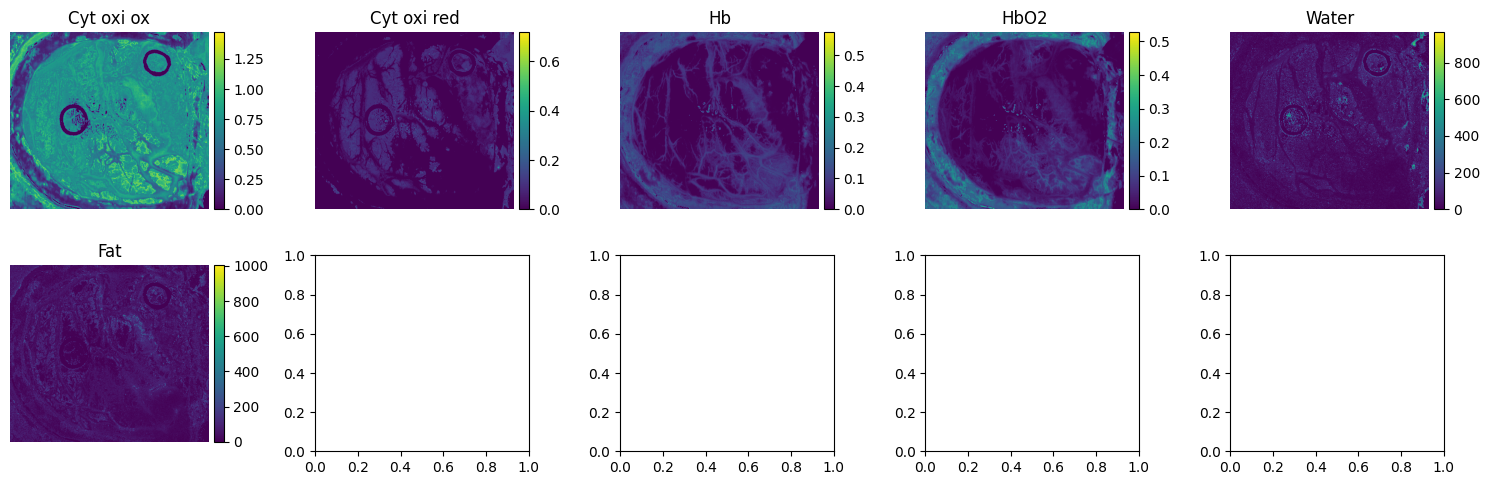

In [19]:
print(concentrations.shape)
fig, ax = plot_concentrations(concentrations, endmember_labels)
# fig.savefig("scatter_ls.svg", bbox_inches="tight", format="svg")

# plt.figure()
# plt.imshow(np.log(concentrations[:,:,5]+1))


gradient descent

In [9]:
def f(c, pixel_spectrum):
    spectrum_model = (P_E @ (I_white * np.exp(M_optim @ c))) 
    spectrum_model /= np.linalg.norm(spectrum_model) + 1e-8
    err = np.linalg.norm(pixel_spectrum - spectrum_model)
    print(err)
    return err

def d_f(c, pixel_spectrum):
    grad = np.zeros(c.shape)
    eps = 1e-6
    for i in range(c.shape[0]):
        # positivity constraint
        if c[i] < 0:
            grad[i] = 0
        dc = np.zeros_like(c)
        dc[i] = eps
        grad[i] = (f(c + dc, pixel_spectrum) - f(c, pixel_spectrum))/eps
    return grad

def optimize_scatter(img_proj):
    result = np.zeros([img_proj.shape[0], img_proj.shape[1], M_optim.shape[1]])
    for i in tqdm(range(img_proj.shape[0])):
        for j in range(img_proj.shape[1]):
            pixel_spectrum = img_proj[i, j, :]/np.linalg.norm(img_proj[i,j,:])
            c = np.zeros([M_optim.shape[1]])
            for k in range(1):
                c -= 0.1*d_f(c, pixel_spectrum)
            result[i,j,:] = c
    return result 

# concentrations = optimize_scatter(img_proj)

### Dimensionality reduction of result

In [20]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def plot_pca_tsne(spectr, gt_map, class_labels):

    np.random.seed(0)
    N = spectr[np.where(gt_map.asarray()[:,:,0] == 1)]
    T = spectr[np.where(gt_map.asarray()[:,:,0] == 2)]
    B = spectr[np.where(gt_map.asarray()[:,:,0] == 3)]

    # select random samples from each class such that the number of samples is equal to the smallest class or max_samples
    nsamples = min(N.shape[0], T.shape[0], B.shape[0])

    idx_N = np.random.choice(N.shape[0], nsamples, replace=False)
    N = N[idx_N]
    idx_T = np.random.choice(T.shape[0], nsamples, replace=False)
    T = T[idx_T]
    idx_B = np.random.choice(B.shape[0], nsamples, replace=False)
    B = B[idx_B]

    NTB = np.concatenate((N, T, B))

    pca = PCA(n_components=2)
    NTB_pca = pca.fit_transform(NTB)


    tsne = TSNE(n_components=2)
    NTB_tsne = tsne.fit_transform(NTB)

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    Y = np.repeat([1, 2, 3], nsamples)
    for i in range(1,4):
        axs[0].scatter(NTB_tsne[Y==i, 0], NTB_tsne[Y==i, 1], label=class_labels[i])
        axs[1].scatter(NTB_pca[Y==i, 0], NTB_pca[Y==i, 1], label=class_labels[i])
    axs[0].set_title('t-SNE')
    axs[1].set_title('PCA')
    axs[1].legend()

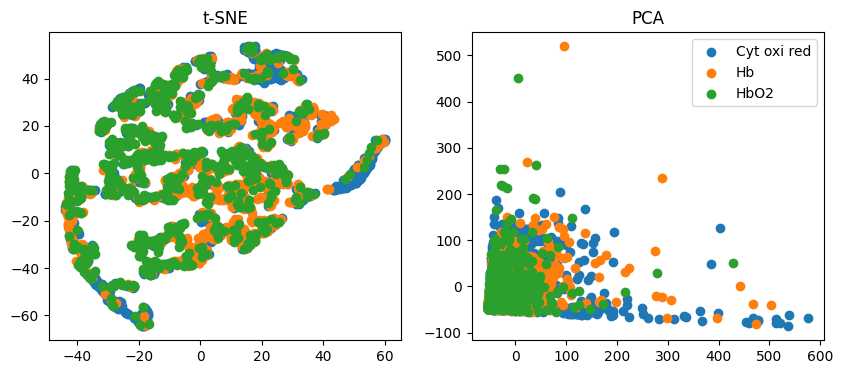

In [22]:
plot_pca_tsne(concentartions, gt_map, endmember_labels)